In [1]:
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW, SGD 


import json


from statistics import mean

In [2]:
import utils_generic as generic
import st_dep as st
import model_confs as confs


import train_datamaps_inprogress as train

from train import eval_func

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [4]:
model_conf = confs.bert_conf
encoding_type = 'pos'
model_name = 'bert'

# Datos ConvAI2

In [5]:
with open('Datasets\ConvAI2\convai2_complete.json','r') as f:
    data = json.load(f)

In [6]:
vocab = generic.Vocabulary(data['train'],encoding_type)

In [7]:
convai_train = data['train']
convai_val = data['validation']



convai_train_token = generic.tokenize_dataset_with_dependencies(convai_train,['about','to','as'],vocab,model_conf) 
convai_val_token = generic.tokenize_dataset_with_dependencies(convai_val,['about','to','as'],vocab,model_conf) 

In [8]:
convai_train_dataset = {}
for task in ['to','as','about']:
    convai_train_dataset[task] = st.DatasetSingleTaskDep(convai_train_token,task,eval=False)

In [9]:
convai_val_dataset = {}
for task in ['to','as','about']:
    convai_val_dataset[task] = st.DatasetSingleTaskDep(convai_val_token,task,eval=False)

# Datos md_gender

In [10]:
with open('Datasets\md_gender\md_complete.json','r',encoding="utf8") as f:
    md_data = json.load(f)

In [11]:
md_tokenized = generic.tokenize_dataset_with_dependencies(md_data,['about','to','as'],vocab,model_conf) 


md_dataset = {}
for task in ['to','as','about']:
    md_dataset[task] = st.DatasetSingleTaskDep(md_tokenized,task,eval=True)

# Creación dataloaders

In [12]:
dl_train = {}
for task in ['to','as','about']:
    dl_train[task] = DataLoader(convai_train_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [13]:
dl_val = {}
for task in ['to','as','about']:
    dl_val[task] = DataLoader(convai_val_dataset[task],batch_size=128,shuffle=True,collate_fn=st.collate_fn)

In [14]:
dl_eval = {}
for task in ['to','as','about']:
    dl_eval[task] = DataLoader(md_dataset[task],batch_size=128,shuffle=False,collate_fn=st.collate_fn)

# ABOUT

In [15]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [16]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5588553261777666 	 Validation loss: 0.395765324770394 	 
  1%|          | 574/57400 [01:46<2:22:11,  6.66it/s]
Epoch 2 	 Training loss: 0.3771423633609499 	 Validation loss: 0.3496768338195348 	 
  2%|▏         | 1148/57400 [03:34<2:22:37,  6.57it/s]
Epoch 3 	 Training loss: 0.3434944648931666 	 Validation loss: 0.3310293727001901 	 
  3%|▎         | 1722/57400 [05:16<2:37:34,  5.89it/s]
Epoch 4 	 Training loss: 0.32359301602591206 	 Validation loss: 0.32333191799915445 	 
  4%|▍         | 2296/57400 [06:55<2:42:35,  5.65it/s]
Epoch 5 	 Training loss: 0.30835890829666984 	 Validation loss: 0.31630985741898165 	 
  5%|▌         | 2870/57400 [08:35<2:28:19,  6.13it/s]
Epoch 6 	 Training loss: 0.29487569380927997 	 Validation loss: 0.3079874457444175 	 
  6%|▌         | 3444/57400 [10:14<2:41:32,  5.57it/s]
Epoch 7 	 Training loss: 0.2841765610338919 	 Validation loss: 0.30562196192094837 	 
  7%|▋         | 4018/57400 [11:54<2:22:08,  6.26it/s]
Epoch 8 	 Traini

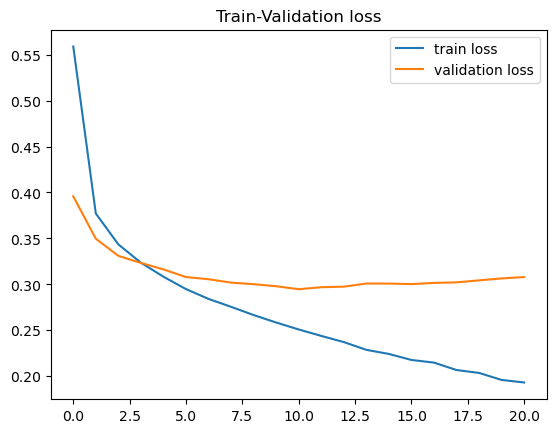

In [17]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [18]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8475, 'male': 0.8697916666666666, 'average': 0.8586458333333333}
precision {'female': 0.87146529562982, 'male': 0.8455696202531645, 'average': 0.8585174579414923}
f1 {'female': 0.8593155893536121, 'male': 0.8575096277278561, 'average': 0.8584126085407341}
accuracy 0.8584183673469388


Evaluación en el conjunto el conjunto to
recall {'female': 0.6614173228346457, 'male': 0.708029197080292, 'average': 0.6847232599574689}
precision {'female': 0.6774193548387096, 'male': 0.6928571428571428, 'average': 0.6851382488479263}
f1 {'female': 0.6693227091633466, 'male': 0.7003610108303249, 'average': 0.6848418599968358}
accuracy 0.6856060606060606


Evaluación en el conjunto el conjunto as
recall {'female': 0.6711590296495957, 'male': 0.7095959595959596, 'average': 0.6903774946227776}
precision {'female': 0.6840659340659341, 'male': 0.6972704714640199, 'average': 0.690668202764977}
f1 {'female': 0.6775510204081633, 'male': 0.7033792

In [19]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about2'


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5567534998422716 	 Validation loss: 0.40055145196995495 	 
  1%|          | 574/57400 [01:39<2:35:08,  6.11it/s]
Epoch 2 	 Training loss: 0.3786694118525924 	 Validation loss: 0.3478476377361912 	 
  2%|▏         | 1148/57400 [03:19<2:37:32,  5.95it/s]
Epoch 3 	 Training loss: 0.34184910764573756 	 Validation loss: 0.33295340179386784 	 
  3%|▎         | 1722/57400 [04:59<2:35:48,  5.96it/s]
Epoch 4 	 Training loss: 0.3229321498125272 	 Validation loss: 0.32412390385643913 	 
  4%|▍         | 2296/57400 [06:38<2:31:47,  6.05it/s]
Epoch 5 	 Training loss: 0.30650749504046987 	 Validation loss: 0.3166184021254717 	 
  5%|▌         | 2870/57400 [08:18<2:30:53,  6.02it/s]
Epoch 6 	 Training loss: 0.2942400847785564 	 Validation loss: 0.3114421420683295 	 
  6%|▌         | 3444/57400 [09:57<2:24:51,  6.21it/s]
Epoch 7 	 Training loss: 0.28098863025783244 	 Validation loss: 0.30607724341295534 	 
  7%|▋         | 4018/57400 [11:36<2:26:37,  6.07it/s]
Epoch 8 	 Trai

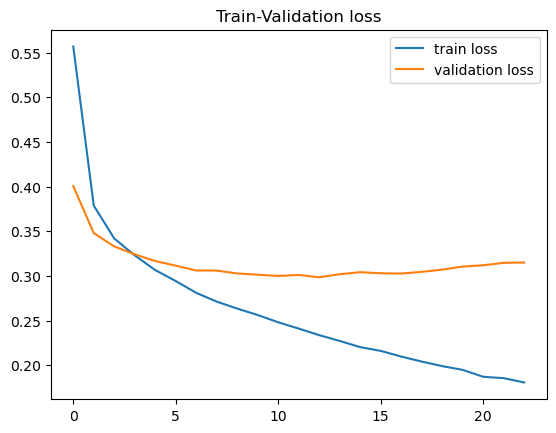

In [20]:

optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p =train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [21]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8375, 'male': 0.8697916666666666, 'average': 0.8536458333333333}
precision {'female': 0.8701298701298701, 'male': 0.8370927318295739, 'average': 0.8536113009797219}
f1 {'female': 0.8535031847133757, 'male': 0.8531289910600255, 'average': 0.8533160878867005}
accuracy 0.8533163265306123


Evaluación en el conjunto el conjunto to
recall {'female': 0.6482939632545932, 'male': 0.6982968369829684, 'average': 0.6732954001187808}
precision {'female': 0.6657681940700808, 'male': 0.6817102137767221, 'average': 0.6737392039234015}
f1 {'female': 0.6569148936170213, 'male': 0.6899038461538461, 'average': 0.6734093698854338}
accuracy 0.6742424242424242


Evaluación en el conjunto el conjunto as
recall {'female': 0.6576819407008087, 'male': 0.7070707070707071, 'average': 0.6823763238857579}
precision {'female': 0.6777777777777778, 'male': 0.687960687960688, 'average': 0.682869232869233}
f1 {'female': 0.667578659370725, 'male': 0.697384

In [22]:
model =st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_about3'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.5733646187632757 	 Validation loss: 0.4180781326051486 	 
  1%|          | 574/57400 [01:40<2:45:12,  5.73it/s]
Epoch 2 	 Training loss: 0.386564314988432 	 Validation loss: 0.3488082441232972 	 
  2%|▏         | 1148/57400 [03:19<2:34:18,  6.08it/s]
Epoch 3 	 Training loss: 0.34453287596071225 	 Validation loss: 0.3318272712877241 	 
  3%|▎         | 1722/57400 [04:59<2:14:31,  6.90it/s]
Epoch 4 	 Training loss: 0.3232474437158698 	 Validation loss: 0.32031834807436343 	 
  4%|▍         | 2296/57400 [06:39<2:31:14,  6.07it/s]
Epoch 5 	 Training loss: 0.3072744817683921 	 Validation loss: 0.316526579907385 	 
  5%|▌         | 2870/57400 [08:18<2:13:41,  6.80it/s]
Epoch 6 	 Training loss: 0.29452376444061457 	 Validation loss: 0.31050910232430795 	 
  6%|▌         | 3444/57400 [09:57<2:38:45,  5.66it/s]
Epoch 7 	 Training loss: 0.28250260399297555 	 Validation loss: 0.3057181701316672 	 
  7%|▋         | 4018/57400 [11:37<2:27:06,  6.05it/s]
Epoch 8 	 Training

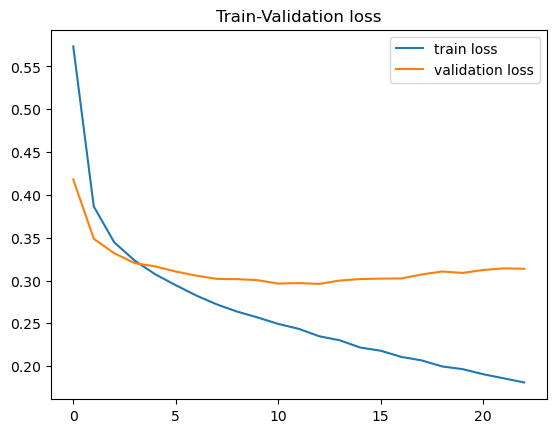

In [23]:


optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['about'],optimizer,early_stop=10,dl_val=dl_val['about'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [24]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.83, 'male': 0.859375, 'average': 0.8446875}
precision {'female': 0.8601036269430051, 'male': 0.8291457286432161, 'average': 0.8446246777931106}
f1 {'female': 0.8447837150127224, 'male': 0.843989769820972, 'average': 0.8443867424168472}
accuracy 0.8443877551020408


Evaluación en el conjunto el conjunto to
recall {'female': 0.6325459317585301, 'male': 0.7055961070559611, 'average': 0.6690710194072456}
precision {'female': 0.6657458563535912, 'male': 0.6744186046511628, 'average': 0.670082230502377}
f1 {'female': 0.648721399730821, 'male': 0.689655172413793, 'average': 0.6691882860723071}
accuracy 0.6704545454545454


Evaluación en el conjunto el conjunto as
recall {'female': 0.6738544474393531, 'male': 0.7070707070707071, 'average': 0.6904625772550301}
precision {'female': 0.6830601092896175, 'male': 0.6982543640897756, 'average': 0.6906572366896966}
f1 {'female': 0.6784260515603798, 'male': 0.7026348808030113, 'average':

Resultados finales

In [25]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.8520384796147606
f1 etiqueta male: 0.8515427962029511
f1 etiqueta female:  0.85253416302657


TO
Resultado global f1: 0.6758131719848589
f1 etiqueta male: 0.693306676465988
f1 etiqueta female:  0.6583196675037296


AS
Resultado global f1: 0.6878257738576942
f1 etiqueta male: 0.701132970602299
f1 etiqueta female:  0.6745185771130894


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.8523263888888889
recall etiqueta male: 0.8663194444444444
recall etiqueta female:  0.8383333333333334


TO
Resultado global recall: 0.6756965598278317
recall etiqueta male: 0.7039740470397405
recall etiqueta female:  0.647419072615923


AS
Resultado global recall: 0.6877387985878552
recall etiqueta male: 0.7079124579124579
recall etiqueta female:  0.6675651392632524


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.8522511455714415
precision etiqueta male: 0.8372693602419848
precision etiqueta female:  0.867232

# TO

In [23]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [24]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6968735413891929 	 Validation loss: 0.6921897136558921 	 
  1%|          | 574/57400 [01:49<2:53:17,  5.47it/s]
Epoch 2 	 Training loss: 0.6954438461036216 	 Validation loss: 0.6923242817490788 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:37<2:33:41,  6.10it/s]
Epoch 3 	 Training loss: 0.6945944979838793 	 Validation loss: 0.6948665430990316 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:26<2:45:50,  5.60it/s]
Epoch 4 	 Training loss: 0.6939410439559391 	 Validation loss: 0.6926598144789874 	 

3 epoch without improvement
  4%|▍         | 2296/57400 [07:14<2:46:23,  5.52it/s]
Epoch 5 	 Training loss: 0.6934125449391607 	 Validation loss: 0.6917922335155939 	 
  5%|▌         | 2870/57400 [09:04<2:24:53,  6.27it/s]
Epoch 6 	 Training loss: 0.6935251372824147 	 Validation loss: 0.6954337974726144 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:53<2:45:42,  5.43it/s]
Epoch 7 	 Training loss: 0.6933420981679644 	

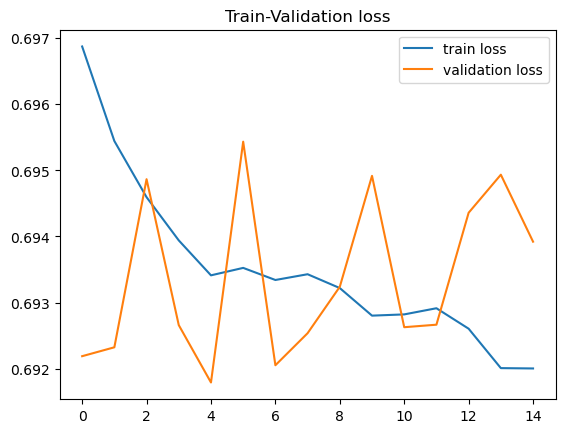

In [26]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [25]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8075, 'male': 0.2526041666666667, 'average': 0.5300520833333333}
precision {'female': 0.5295081967213114, 'male': 0.5574712643678161, 'average': 0.5434897305445638}
f1 {'female': 0.6396039603960395, 'male': 0.3476702508960573, 'average': 0.4936371056460484}
accuracy 0.5357142857142857


Evaluación en el conjunto el conjunto to
recall {'female': 0.7427821522309711, 'male': 0.30170316301703165, 'average': 0.5222426576240013}
precision {'female': 0.4964912280701754, 'male': 0.5585585585585585, 'average': 0.527524893314367}
f1 {'female': 0.5951629863301788, 'male': 0.391785150078989, 'average': 0.49347406820458395}
accuracy 0.5138888888888888


Evaluación en el conjunto el conjunto as
recall {'female': 0.7304582210242587, 'male': 0.29797979797979796, 'average': 0.5142190095020284}
precision {'female': 0.4936247723132969, 'male': 0.5412844036697247, 'average': 0.5174545879915108}
f1 {'female': 0.5891304347826086, 'male': 0.38

In [26]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to2'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6960051639154813 	 Validation loss: 0.6934209678132656 	 
  1%|          | 574/57400 [01:50<2:52:44,  5.48it/s]
Epoch 2 	 Training loss: 0.695054519155715 	 Validation loss: 0.6945516345864635 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:38<2:52:53,  5.42it/s]
Epoch 3 	 Training loss: 0.6945674023769458 	 Validation loss: 0.6938597458904072 	 

2 epoch without improvement
  3%|▎         | 1722/57400 [05:28<2:58:00,  5.21it/s]
Epoch 4 	 Training loss: 0.6938185467537272 	 Validation loss: 0.6927955312243963 	 
  4%|▍         | 2296/57400 [07:17<2:17:54,  6.66it/s]
Epoch 5 	 Training loss: 0.6938247709739499 	 Validation loss: 0.692923357931234 	 

1 epoch without improvement
  5%|▌         | 2870/57400 [09:07<2:46:16,  5.47it/s]
Epoch 6 	 Training loss: 0.6933710248005099 	 Validation loss: 0.6943403805716563 	 

2 epoch without improvement
  6%|▌         | 3444/57400 [10:56<2:18:51,  6.48it/s]
Epoch 7 	 Training loss: 0.6933987389873545 	 V

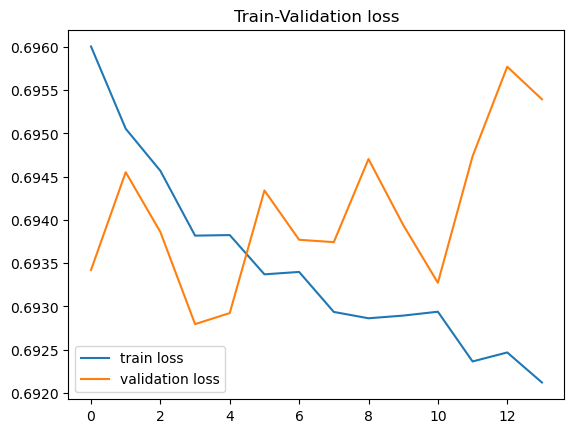

In [29]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [27]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.3825, 'male': 0.6458333333333334, 'average': 0.5141666666666667}
precision {'female': 0.5294117647058824, 'male': 0.501010101010101, 'average': 0.5152109328579917}
f1 {'female': 0.4441219158200291, 'male': 0.5642775881683733, 'average': 0.5041997519942012}
accuracy 0.5114795918367347


Evaluación en el conjunto el conjunto to
recall {'female': 0.33070866141732286, 'male': 0.6861313868613139, 'average': 0.5084200241393184}
precision {'female': 0.49411764705882355, 'male': 0.5251396648044693, 'average': 0.5096286559316464}
f1 {'female': 0.39622641509433965, 'male': 0.5949367088607596, 'average': 0.4955815619775496}
accuracy 0.5151515151515151


Evaluación en el conjunto el conjunto as
recall {'female': 0.3638814016172507, 'male': 0.6616161616161617, 'average': 0.5127487816167062}
precision {'female': 0.5018587360594795, 'male': 0.5261044176706827, 'average': 0.5139815768650811}
f1 {'female': 0.421875, 'male': 0.58612975391

In [28]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_to3'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6967233781822882 	 Validation loss: 0.694895578643023 	 
  1%|          | 574/57400 [01:50<2:31:40,  6.24it/s]
Epoch 2 	 Training loss: 0.6951389425930661 	 Validation loss: 0.691829875364142 	 
  2%|▏         | 1148/57400 [03:39<2:49:47,  5.52it/s]
Epoch 3 	 Training loss: 0.6945885354425849 	 Validation loss: 0.6931611491461932 	 

1 epoch without improvement
  3%|▎         | 1722/57400 [05:28<2:39:22,  5.82it/s]
Epoch 4 	 Training loss: 0.6939119860685661 	 Validation loss: 0.6925171199491469 	 

2 epoch without improvement
  4%|▍         | 2296/57400 [07:18<2:47:06,  5.50it/s]
Epoch 5 	 Training loss: 0.6939925857744981 	 Validation loss: 0.6938200037358171 	 

3 epoch without improvement
  5%|▌         | 2870/57400 [09:07<2:43:12,  5.57it/s]
Epoch 6 	 Training loss: 0.6937007944550664 	 Validation loss: 0.6931265481447769 	 

4 epoch without improvement
  6%|▌         | 3444/57400 [10:56<2:37:17,  5.72it/s]
Epoch 7 	 Training loss: 0.6936351965321066 	 V

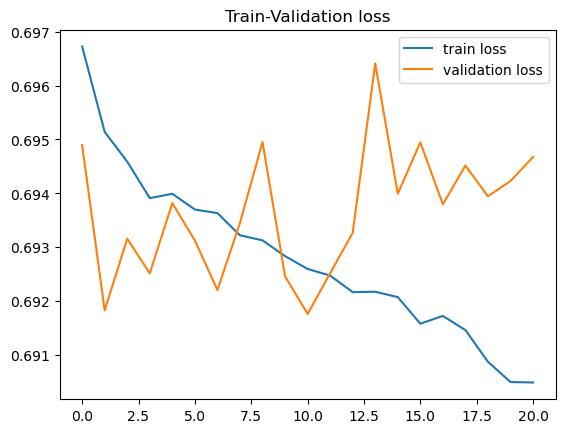

In [32]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p = train.train_function(model,num_epochs,dl_train['to'],optimizer,early_stop=10,dl_val=dl_val['to'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [29]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.2475, 'male': 0.9010416666666666, 'average': 0.5742708333333333}
precision {'female': 0.7226277372262774, 'male': 0.5347758887171561, 'average': 0.6287018129717168}
f1 {'female': 0.3687150837988827, 'male': 0.6711930164888458, 'average': 0.5199540501438642}
accuracy 0.5676020408163265


Evaluación en el conjunto el conjunto to
recall {'female': 0.19160104986876642, 'male': 0.8613138686131386, 'average': 0.5264574592409526}
precision {'female': 0.5615384615384615, 'male': 0.5347432024169184, 'average': 0.5481408319776899}
f1 {'female': 0.28571428571428575, 'male': 0.6598322460391426, 'average': 0.4727732658767142}
accuracy 0.5391414141414141


Evaluación en el conjunto el conjunto as
recall {'female': 0.215633423180593, 'male': 0.8333333333333334, 'average': 0.5244833782569632}
precision {'female': 0.547945205479452, 'male': 0.5314009661835749, 'average': 0.5396730858315135}
f1 {'female': 0.30947775628626695, 'male': 0.64

Resultados finales

In [31]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.5059303025947046
f1 etiqueta male: 0.5277136185177588
f1 etiqueta female:  0.4841469866716504


TO
Resultado global f1: 0.4872762986862826
f1 etiqueta male: 0.548851368326297
f1 etiqueta female:  0.42570122904626806


AS
Resultado global f1: 0.48999088624219816
f1 etiqueta male: 0.5398207087947711
f1 etiqueta female:  0.4401610636896252


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.5394965277777778
recall etiqueta male: 0.5998263888888888
recall etiqueta female:  0.4791666666666667


TO
Resultado global recall: 0.5190400470014241
recall etiqueta male: 0.6163828061638281
recall etiqueta female:  0.4216972878390201


AS
Resultado global recall: 0.5171503897918993
recall etiqueta male: 0.5976430976430976
recall etiqueta female:  0.4366576819407008


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.5624674921247574
precision etiqueta male: 0.5310857513650244
precision etiqueta female:  0.

# AS

In [32]:
learning_rate = 1e-6
num_epochs = 100

global_metrics = {'about':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'to':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]},
                    'as':{'recall':{'average':[],'female':[],'male':[]},
                            'precision':{'average':[],'female':[],'male':[]},
                            'f1':{'average':[],'female':[],'male':[]},
                            'acc':[]}}

In [33]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as1'


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.7013156639366616 	 Validation loss: 0.6934879967721842 	 
  1%|          | 574/57400 [01:49<2:57:27,  5.34it/s]
Epoch 2 	 Training loss: 0.6955376927860938 	 Validation loss: 0.6932029491764004 	 
  2%|▏         | 1148/57400 [03:39<2:51:41,  5.46it/s]
Epoch 3 	 Training loss: 0.6946427431671461 	 Validation loss: 0.6915787812006675 	 
  3%|▎         | 1722/57400 [05:29<3:10:57,  4.86it/s]
Epoch 4 	 Training loss: 0.6930855885407651 	 Validation loss: 0.6925830750142113 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [07:17<2:42:30,  5.65it/s]
Epoch 5 	 Training loss: 0.6918567664116517 	 Validation loss: 0.6916166523755607 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [09:06<2:45:01,  5.51it/s]
Epoch 6 	 Training loss: 0.6898623385080477 	 Validation loss: 0.6920534160177586 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [10:55<2:51:25,  5.25it/s]
Epoch 7 	 Training loss: 0.6882091503110082 	 Validation loss: 0.693549237

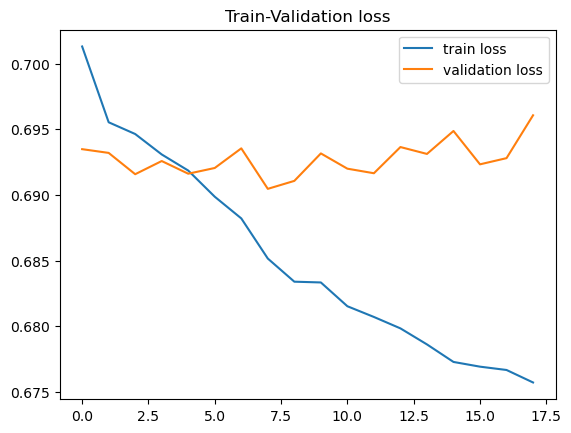

In [37]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [34]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.8425, 'male': 0.5026041666666666, 'average': 0.6725520833333334}
precision {'female': 0.6382575757575758, 'male': 0.75390625, 'average': 0.6960819128787878}
f1 {'female': 0.7262931034482759, 'male': 0.603125, 'average': 0.664709051724138}
accuracy 0.6760204081632653


Evaluación en el conjunto el conjunto to
recall {'female': 0.8031496062992126, 'male': 0.49878345498783455, 'average': 0.6509665306435236}
precision {'female': 0.59765625, 'male': 0.7321428571428571, 'average': 0.6648995535714286}
f1 {'female': 0.685330347144457, 'male': 0.5933429811866859, 'average': 0.6393366641655714}
accuracy 0.6452020202020202


Evaluación en el conjunto el conjunto as
recall {'female': 0.9164420485175202, 'male': 0.5580808080808081, 'average': 0.7372614282991641}
precision {'female': 0.6601941747572816, 'male': 0.876984126984127, 'average': 0.7685891508707043}
f1 {'female': 0.7674943566591421, 'male': 0.6820987654320988, 'average': 0.

In [35]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as2'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.6992519442835752 	 Validation loss: 0.6915402422517033 	 
  1%|          | 574/57400 [01:49<2:28:32,  6.38it/s]
Epoch 2 	 Training loss: 0.6948979587297406 	 Validation loss: 0.6932210528244407 	 

1 epoch without improvement
  2%|▏         | 1148/57400 [03:38<2:29:44,  6.26it/s]
Epoch 3 	 Training loss: 0.6943020607743945 	 Validation loss: 0.6907405166302697 	 
  3%|▎         | 1722/57400 [05:28<2:51:49,  5.40it/s]
Epoch 4 	 Training loss: 0.6930549496765336 	 Validation loss: 0.6932519260099379 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [07:17<2:46:01,  5.53it/s]
Epoch 5 	 Training loss: 0.6917311326967299 	 Validation loss: 0.6923691499031196 	 

2 epoch without improvement
  5%|▌         | 2870/57400 [09:05<2:22:57,  6.36it/s]
Epoch 6 	 Training loss: 0.6900765849115126 	 Validation loss: 0.6916752306081481 	 

3 epoch without improvement
  6%|▌         | 3444/57400 [10:55<2:36:46,  5.74it/s]
Epoch 7 	 Training loss: 0.688588206880184 	 

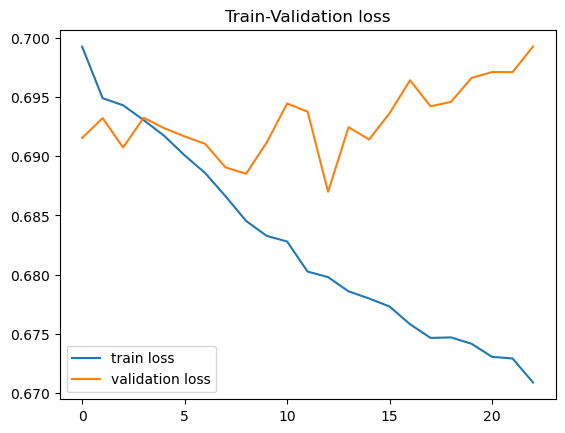

In [40]:
optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay=0.1)
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [36]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.735, 'male': 0.6041666666666666, 'average': 0.6695833333333333}
precision {'female': 0.6591928251121076, 'male': 0.6863905325443787, 'average': 0.6727916788282431}
f1 {'female': 0.6950354609929078, 'male': 0.6426592797783933, 'average': 0.6688473703856506}
accuracy 0.6709183673469388


Evaluación en el conjunto el conjunto to
recall {'female': 0.7322834645669292, 'male': 0.6885644768856448, 'average': 0.7104239707262869}
precision {'female': 0.6855036855036855, 'male': 0.7350649350649351, 'average': 0.7102843102843103}
f1 {'female': 0.7081218274111675, 'male': 0.7110552763819096, 'average': 0.7095885518965386}
accuracy 0.7095959595959596


Evaluación en el conjunto el conjunto as
recall {'female': 0.8221024258760108, 'male': 0.696969696969697, 'average': 0.7595360614228539}
precision {'female': 0.7176470588235294, 'male': 0.8070175438596491, 'average': 0.7623323013415892}
f1 {'female': 0.7663316582914573, 'male': 0.74796

In [37]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
save_path=f'{model_name}_{encoding_type}_as3'

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/57400 [00:00<?, ?it/s]

Epoch 1 	 Training loss: 0.7027558605430018 	 Validation loss: 0.7070267554056846 	 
  1%|          | 574/57400 [01:50<2:24:57,  6.53it/s]
Epoch 2 	 Training loss: 0.7025681601168802 	 Validation loss: 0.7060078998743478 	 
  2%|▏         | 1148/57400 [03:39<2:48:55,  5.55it/s]
Epoch 3 	 Training loss: 0.7018428136455057 	 Validation loss: 0.7044903534953877 	 
  3%|▎         | 1722/57400 [05:30<2:25:38,  6.37it/s]
Epoch 4 	 Training loss: 0.7023205338662509 	 Validation loss: 0.7070299195030988 	 

1 epoch without improvement
  4%|▍         | 2296/57400 [07:19<2:43:04,  5.63it/s]
Epoch 5 	 Training loss: 0.7029422853881889 	 Validation loss: 0.7043464193909855 	 
  5%|▌         | 2870/57400 [09:08<2:47:57,  5.41it/s]
Epoch 6 	 Training loss: 0.70184138053801 	 Validation loss: 0.7053749652232154 	 

1 epoch without improvement
  6%|▌         | 3444/57400 [10:57<2:37:25,  5.71it/s]
Epoch 7 	 Training loss: 0.7021165647988535 	 Validation loss: 0.7063889412556664 	 

2 epoch without imp

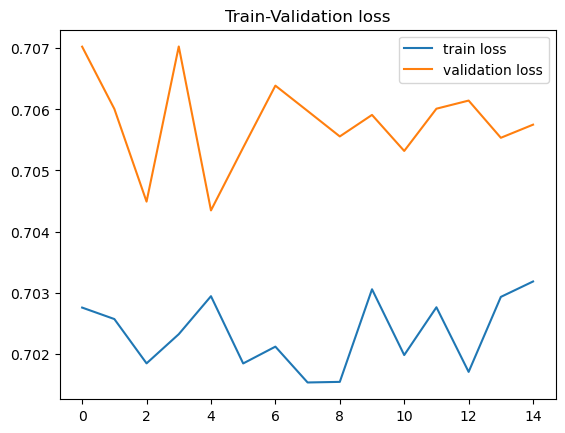

In [43]:
p= train.train_function(model,num_epochs,dl_train['as'],optimizer,early_stop=10,dl_val=dl_val['as'],save_path=save_path,es_threshold=0)
torch.save(p,save_path+'.pt')

In [38]:
model = st.SingleTaskDep(model_conf,vocab,num_labels=2).to(device)
model.load_state_dict(torch.load(save_path))
for task in ['about','to','as']:
    print('\n')
    print(f"Evaluación en el conjunto el conjunto {task}")
    metric_result = eval_func(model,dl_eval[task])
    for metric, value in metric_result.items():
        if metric=='accuracy':
            global_metrics[task]['acc'].append(value) 
        else:
            for g,v in value.items():
                global_metrics[task][metric][g].append(v)

        print(metric,metric_result[metric])

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).




Evaluación en el conjunto el conjunto about
recall {'female': 0.01, 'male': 0.9895833333333334, 'average': 0.4997916666666667}
precision {'female': 0.5, 'male': 0.4896907216494845, 'average': 0.4948453608247423}
f1 {'female': 0.0196078431372549, 'male': 0.6551724137931034, 'average': 0.3373901284651792}
accuracy 0.4897959183673469


Evaluación en el conjunto el conjunto to
recall {'female': 0.007874015748031496, 'male': 0.9951338199513382, 'average': 0.5015039178496848}
precision {'female': 0.6, 'male': 0.5196950444726811, 'average': 0.5598475222363406}
f1 {'female': 0.015544041450777204, 'male': 0.682804674457429, 'average': 0.3491743579541031}
accuracy 0.5202020202020202


Evaluación en el conjunto el conjunto as
recall {'female': 0.01078167115902965, 'male': 0.9873737373737373, 'average': 0.4990777042663835}
precision {'female': 0.4444444444444444, 'male': 0.5158311345646438, 'average': 0.4801377895045441}
f1 {'female': 0.02105263157894737, 'male': 0.677642980935875, 'average': 0.

Resultados finales

In [39]:
for metric in ['f1','recall','precision']:
    print(f'{metric} medio de los 3 modelos: \n')
    for task in ['about','to','as']:
        print(task.upper())
        print(f'Resultado global {metric}:',mean(global_metrics[task][metric]['average'])) 
        print(f'{metric} etiqueta male:',mean(global_metrics[task][metric]['male']))
        print(f'{metric} etiqueta female: ',mean(global_metrics[task][metric]['female']))
        print('\n')

print(f'Accuracy medio de los 3 modelos: \n')
for task in ['about','to','as']:
    print('\n',task.upper())
    print('Resultado global accuracy:',mean(global_metrics[task]['acc']))

f1 medio de los 3 modelos: 

ABOUT
Resultado global f1: 0.5569821835249893
f1 etiqueta male: 0.633652231190499
f1 etiqueta female:  0.4803121358594795


TO
Resultado global f1: 0.5660331913387378
f1 etiqueta male: 0.6624009773420082
f1 etiqueta female:  0.4696654053354672


AS
Resultado global f1: 0.6104313120953861
f1 etiqueta male: 0.7025697420142568
f1 etiqueta female:  0.5182928821765156


recall medio de los 3 modelos: 

ABOUT
Resultado global recall: 0.6139756944444444
recall etiqueta male: 0.6987847222222222
recall etiqueta female:  0.5291666666666667


TO
Resultado global recall: 0.6209648064064984
recall etiqueta male: 0.7274939172749392
recall etiqueta female:  0.5144356955380578


AS
Resultado global recall: 0.6652917313294672
recall etiqueta male: 0.7474747474747475
recall etiqueta female:  0.5831087151841868


precision medio de los 3 modelos: 

ABOUT
Resultado global precision: 0.6212396508439244
precision etiqueta male: 0.643329168064621
precision etiqueta female:  0.599